![River-logo](../assets/river_logo.png)

# General introduction to River and its functionality

`River` is a Python library for online machine learning. It first appears on November 2020, which is a result of a merge between [`creme`](https://github.com/MaxHalford/creme) and [`scikit-multiflow`](https://github.com/scikit-multiflow/scikit-multiflow).

Currently, with more than 3000 stars on `Github` and itself being applied in various data science project at major tech firms (Samsung/Harman Kardon, Bee2Beep, BNP Paribas, Lyft, etc.), `River` has turned itself to become a go-to library for machine learning on streaming data.

Key features of `River`:

* **Incremental learning**: For all models within `River`, only one sample is updated at a time.
* **Adaptive learning**: Methods are robust against any concept drift/anomalies in dynamic situations.
* **General**: `River` is designed for all-purpose use, just like `scikit-learn`. Models within the package deals with all kinds of problems, including regression, classification, clustering, and even ad-hoc tasks like pre-processing, etc.
* **Efficient**: Streaming methods in `River` are designed to consume time and memory at an efficient manner, mostly sub-linear.
* **Easy to use**: `River` is suitable for use at any experience level, from beginners to experts/researchers.

# From batch learning to stream learning

## Batch learning

Batch learning assumes that **all** data is available at the same time, for both training and testing, and is processed in batches or as a whole.

A minimal pipeline for traditional machine learning includes:

1. Data preprocessing and engineering
1. Training
1. Testing

We will take an example with [`Iris`](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), a dataset that everyone in the world of machine learning should all have heard of, at least once. This is available as part of `scikit-learn`.

With this dataset, we will use $75\%$ of them for training, and the remaining $25\%$ for testing. The training and testing set have to be totally separated from each other, i.e they cannot overlap on one another.

In [1]:
from sklearn import datasets as datasets_skl
from sklearn.naive_bayes import GaussianNB as GaussianNB_skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
iris = datasets_skl.load_iris()

# load variables and output into different variables
x = iris.data
y = iris.target

# split into training and testing set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, stratify=y, random_state=0
)

In [3]:
# shape of datasets
print(f"Shape of iris: {iris.data.shape}, "
      f"training set: {x_train.shape}, testing set: {x_test.shape}")

# feature names
print(f"The iris feature names include:", 
      ', '.join(str(p) for p in iris.feature_names))

# target names
print(f"The iris target names (groups) include:", 
      ', '.join(str(p) for p in iris.feature_names))

Shape of iris: (150, 4), training set: (112, 4), testing set: (38, 4)
The iris feature names include: sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)
The iris target names (groups) include: sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)


This is a classification problem, with $4$ features and $3$ groups (target names). As such, for this problem, we will use the Gaussian Naive Bayes (`GaussianNB`) for a parallel comparision against its incremental version in `River`.

In [4]:
gaussiannb_sklearn = GaussianNB_skl()
gaussiannb_sklearn.fit(X=x_train, y=y_train)
y_pred = gaussiannb_sklearn.predict(X=x_test)

In [5]:
# derive accuracy
print(f"SKLearn's Gaussian Naive Bayes accuracy: {accuracy_score(y_test, y_pred):.5f}")

SKLearn's Gaussian Naive Bayes accuracy: 0.97368


A model accuracy of $97\%$, given that the dataset is simple and has a small number of data points, is indeed acceptable. However, in real life scenarios, generally speaking, we can not have all the data available at the same time. In fact, they usually come at a constant rate, which means that we have to collect data over time and generate new models after a certain time window.

However, this approach raises a lot of relevant questions, include

* Should we train new models on new data or even old data? To what time point?
* How much new data is enough to start creating a new model?
* How much should the new model be better than the old one, in terms of cost effectiveness?
* Storing data (especially for big data problems) is sometimes not feasible, impratical and/or too costly
* etc.

All of these problems, combined, triggered the formation of stream learning practices.

## Stream learning

Under the assumtion that

* Data comes in a stream, which means that we do not have all the data available at the same time;
* The number of data points are infinite; and 
* The statistics of the future-coming points are not predictable.

The stream learning methods are specifically designed to deal with this situation under a certain set of requirements:

* **Data are processed at one sample at a time.**: A sample is only seen once (learned once) and then the information regarding this point is totally forgotten after processing.
* **Time and memory efficient**: Although the data stream is infinite, the algorithm must be designed to be efficient enough to handle a large number of data points coming in a continuous pattern. Most online learning algorithms deemed to use resources at a sub-linear fashion.
* **Able to predict at any time**: The model can provide predictions for any data point coming at any time.

Within the scope of this demo, the stream can be simulated by iterating through the whole dataset, *one observation at a time* with `zip`.

In [6]:
for x_i, y_i in zip(x_train, y_train):
    # TBA
    pass
x_i, y_i # final observation

(array([6.4, 2.7, 5.3, 1.9]), 2)

When dealing with a large number of data in 2D, `numpy.ndarrays` are much more preferred. Most machine learning packages in Python, including `scikit-learn`, natively deals with this type of data. 

However, when dealing with data coming in a streaming fashion, particularly under the assumption that data only comes one point at a time as one-dimensional arrays, dictionary is much more preferred. As such, when feeding the data into `River`'s algorithms, we need a bit of transformation. This can easily be done as follows:

In [7]:
for x_i, y_i in zip(x_train, y_train):
    x_i_dict = dict(zip(iris.feature_names, x_i))

x_i_dict, y_i

({'sepal length (cm)': 6.4,
  'sepal width (cm)': 2.7,
  'petal length (cm)': 5.3,
  'petal width (cm)': 1.9},
 2)

Although `scikit-learn` supports certain incremental algorithms (i.e these methods are provided with a `partial_fit` methods), this method only works for  *mini batches* - data that comes in at small batches at the same time.  

This also means that, we are doing "training", and then "testing" later, which is not the suitable practice for fully online machine learing.

In the following example with `River`, we are also using the Gaussian Naive Bayes method, which is an **incremental method** itself. The training and predicting method are provided via `learn_one` and `predict_one`.

### The `progressive_val_score` method

In [8]:
# Imports
from river import evaluate
from river import stream
from river import naive_bayes
from river import metrics

from sklearn.datasets import load_iris

The `progressive_val_score` method implements the **prequential evaluation** and requires three components: 

- a data stream
- a model
- a metric

In [9]:
# Setup stream and estimators
data = stream.iter_sklearn_dataset(datasets_skl.load_iris(), 
                                   shuffle=True, 
                                   seed=42)
nb = naive_bayes.GaussianNB()
metric = metrics.Accuracy()

# Setup evaluator
evaluate.progressive_val_score(dataset=data, 
                               model=nb, 
                               metric=metric, 
                               print_every=15)

[15] Accuracy: 64.29%
[30] Accuracy: 82.76%
[45] Accuracy: 84.09%
[60] Accuracy: 88.14%
[75] Accuracy: 89.19%
[90] Accuracy: 89.89%
[105] Accuracy: 91.35%
[120] Accuracy: 92.44%
[135] Accuracy: 92.54%
[150] Accuracy: 91.95%


Accuracy: 91.95%

### Under the hood

In the streaming setting, training and predicting happen inside a loop. Remember, a data sample is available only once in the stream.

The `iter_sklearn` method converts a `scikit-learn` dataset object into an iterable that returns the data as `dict`. This way, we do not need the manual `zip` command as mentioned previously.

The following example shows the main steps performed by `progressive_val_score`:

In [10]:
model = naive_bayes.GaussianNB()
metric = metrics.Accuracy()
data = stream.iter_sklearn_dataset(load_iris(), shuffle=True, seed=42)
n_passed_samples = 0

y_pred = []
y_true = []

for x, y in data:
    # Predict class
    y_p = model.predict_one(x)                    
    if y_p is not None:
        # Update metric
        metric.update(y_true=y, y_pred=y_p)       
    # Train the model
    model.learn_one(x, y)  
    # Process next sample if the model is empty
    if y_p is None:
        continue
    # Add one to the number of passed samples
    n_passed_samples += 1
    y_pred.append(y_p)
    y_true.append(y)
    if n_passed_samples % 15 == 0:
        print(f'[{metric.cm.n_samples + 1}] {metric}')
        
print(f'Model accuracy calculated by accuracy_score from sklearn: {accuracy_score(y_true, y_pred):.4f}')

[16] Accuracy: 66.67%
[31] Accuracy: 83.33%
[46] Accuracy: 84.44%
[61] Accuracy: 88.33%
[76] Accuracy: 89.33%
[91] Accuracy: 90.00%
[106] Accuracy: 91.43%
[121] Accuracy: 92.50%
[136] Accuracy: 92.59%
Model accuracy calculated by accuracy_score from sklearn: 0.9195


### The order matters!

Notice the *order* of the training and prediction operations.

When a new data sample ($x_i$, $y_i$) arrives:

1. Predict the label $y_i'$ for the new data sample $x_i$, *not yet "seen"* by the model.
2. Train the model using the new sample ($x_i$, $y_i$).

This practice is commonly known as **prequential evaluation** or **interleaved test-then-train** evaluation. This means that, the method is used to predict the outcome of the new data point, even before learning.

A benefit from this approach is that we can use all labeled samples in the stream to measure a model's performance, since the model can provide predictions at any point in the stream, depending on its current internal state. Batch methods can only predict after they have finished training.

In [11]:
model = naive_bayes.GaussianNB()
metric = metrics.Accuracy()
data = stream.iter_sklearn_dataset(load_iris(), shuffle=False)
n_passed_samples = 0

y_pred = []
y_true = []

for x, y in data:
    # Predict class
    y_p = model.predict_one(x)                    
    if y_p is not None:
        # Update metric
        metric.update(y_true=y, y_pred=y_p)       
    # Train the model
    model.learn_one(x, y)  
    # Process next sample if the model is empty
    if y_p is None:
        continue
    # Add one to the number of passed samples
    n_passed_samples += 1
    y_pred.append(y_p)
    y_true.append(y)
    if n_passed_samples % 15 == 0:
        print(f'[{metric.cm.n_samples + 1}] {metric}')
        
print(f'Model accuracy calculated by accuracy_score from sklearn: {accuracy_score(y_true, y_pred):.4f}')

[16] Accuracy: 100.00%
[31] Accuracy: 100.00%
[46] Accuracy: 100.00%
[61] Accuracy: 96.67%
[76] Accuracy: 97.33%
[91] Accuracy: 97.78%
[106] Accuracy: 96.19%
[121] Accuracy: 95.00%
[136] Accuracy: 94.07%
Model accuracy calculated by accuracy_score from sklearn: 0.9463


### Key facts

- We use *all* labeled samples in the stream to measure a model's performance. 
- The model provides predictions at any point in the stream, according to its *current* internal state. Batch methods can only predict after they finished training.
- All methods (models, metrics, etc.) in `River` are updated **one sample at a time**
  - Mini-batch processing is supported by some methods.

### Dictionaries

The default data structure used internally in `River`.

- Efficient storage of 1-dimensional data (1 sample)
- Supports sparse/missing data
- Easy access to features by name (key)

In [12]:
# Last sample from the experiment above
print(x, y)

{'sepal length (cm)': 5.9, 'sepal width (cm)': 3.0, 'petal length (cm)': 5.1, 'petal width (cm)': 1.8} 2


Besides methods, performance metrics in `River` can also be updated with one sample at a time. This means that we do not need to store all true and predicted labels in two separate arrays, which is sometimes *impractical*. 

Moreover, these metrics share the same  **confusion matrix**, which is efficient for calculating various metrics at the same time, for one single data stream.

In [13]:
from river.metrics import Accuracy

metric = Accuracy()
for yt, yp in zip(y_true, y_pred):
    metric.update(y_true=yt, y_pred=yp)
metric

Accuracy: 94.63%

In [14]:
print('Confusion matrix from all data (scikit-learn):')
print(confusion_matrix(y_true, y_pred))
print('Confusion matrix from updatable metric (River):')
print(metric.cm)

Confusion matrix from all data (scikit-learn):
[[49  0  0]
 [ 2 48  0]
 [ 0  6 44]]
Confusion matrix from updatable metric (River):
      0     1     2    
  0    49     0     0  
  1     2    48     0  
  2     0     6    44  


## Decision trees for data streams
---

### `NEWeather` data set

**Description:** The National Oceanic and Atmospheric Administration (NOAA),
has compiled a database of weather measurements from over 7,000 weather 
stations worldwide. Records date back to the mid-1900s. Daily measurements
include a variety of features (temperature, pressure, wind speed, etc.) as
well as a series of indicators for precipitation and other weather-related
events. The `NEweather` data set contains data from this database, specifically
from the Offutt Air Force Base in Bellevue, Nebraska ranging for over 50 years
(1949-1999).

**Features:** 8 Daily weather measurements
 
|       Attribute      | Description |
|:--------------------:|:-----------------------------|
| `temp`                   | Temperature
| `dew_pnt`                | Dew Point
| `sea_lvl_press`          | Sea Level Pressure
| `visibility`             | Visibility
| `avg_wind_spd`           | Average Wind Speed
| `max_sustained_wind_spd` | Maximum Sustained Wind Speed
| `max_temp`               | Maximum Temperature
| `min_temp`               | Minimum Temperature


**Class:** `rain` | 0: no rain, 1: rain
 
**Number of samples:** 18,159

---

In this example, we load the data from a csv file with `pandas.read_csv`. 

Next, we use the `iter_pandas` utility method to iterate over the `DataFrame`. The model in this example is a `HoeffdingTreeClassifier`, a type of decision tree designed for data streams.

In [15]:
import pandas as pd

from river import tree

df = pd.read_csv("../datasets/NEweather.csv")
features = df.columns[:-2]
data = stream.iter_pandas(X=df[features], y=df['rain'])

model = tree.HoeffdingTreeClassifier()
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               print_every=1000)

[1,000] Accuracy: 71.57%
[2,000] Accuracy: 71.54%
[3,000] Accuracy: 71.86%
[4,000] Accuracy: 72.97%
[5,000] Accuracy: 73.13%
[6,000] Accuracy: 73.21%
[7,000] Accuracy: 73.88%
[8,000] Accuracy: 73.57%
[9,000] Accuracy: 73.70%
[10,000] Accuracy: 73.77%
[11,000] Accuracy: 74.15%
[12,000] Accuracy: 74.36%
[13,000] Accuracy: 74.53%
[14,000] Accuracy: 74.38%
[15,000] Accuracy: 74.57%
[16,000] Accuracy: 74.57%
[17,000] Accuracy: 74.46%
[18,000] Accuracy: 74.17%
[18,159] Accuracy: 74.15%


Accuracy: 74.15%

- Tree-based models are popular due to their interpretability.
- They use a tree data structure to model the data.
- When a sample arrives, it traverses the tree until it reaches a leaf node.
- Internal nodes define the path for a data sample based on the values of its features.
- Leaf nodes are models that provide predictions for unlabeled-samples and can update their internal state using the labels from labeled samples.

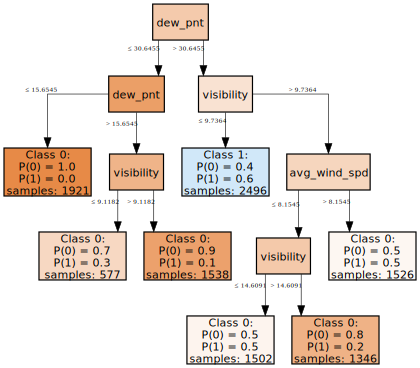

In [16]:
model.draw()

### Incremental tree growth

In [17]:
import itertools

data = stream.iter_pandas(X=df[features], y=df['rain'])
metric = metrics.Accuracy()

model = tree.HoeffdingTreeClassifier()

Running the code chunk within the `for` loop in the following cell multiple times we can "see" the tree growing. 

We have simplified this by using `IPython.display` to return multiple outputs.

Accuracy: 71.50% - n_samples: 1000


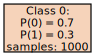

Accuracy: 71.50% - n_samples: 2000


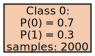

Accuracy: 71.83% - n_samples: 3000


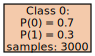

Accuracy: 72.95% - n_samples: 4000


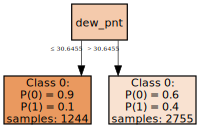

Accuracy: 73.12% - n_samples: 5000


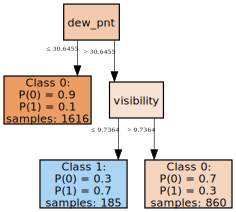

Accuracy: 73.20% - n_samples: 6000


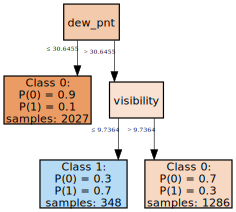

Accuracy: 73.87% - n_samples: 7000


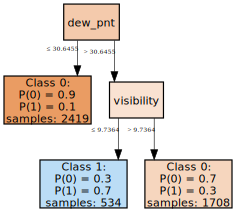

Accuracy: 73.56% - n_samples: 8000


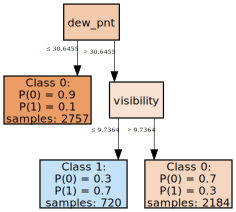

Accuracy: 73.69% - n_samples: 9000


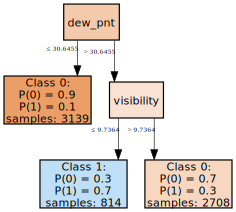

Accuracy: 73.76% - n_samples: 10000


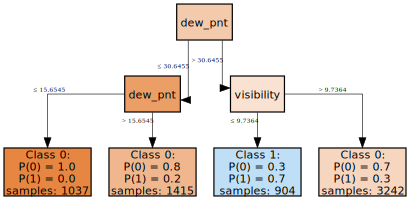

Accuracy: 74.15% - n_samples: 11000


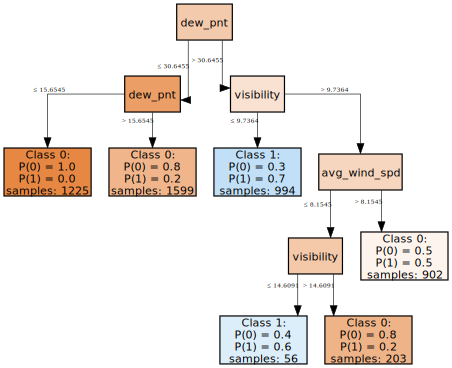

Accuracy: 74.36% - n_samples: 12000


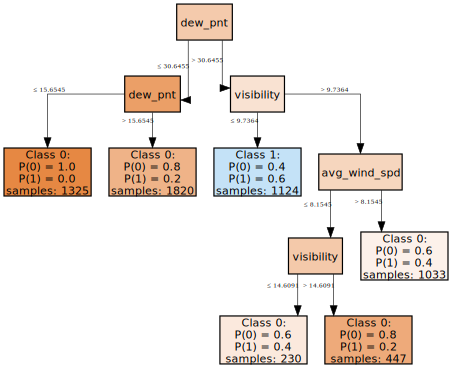

Accuracy: 74.52% - n_samples: 13000


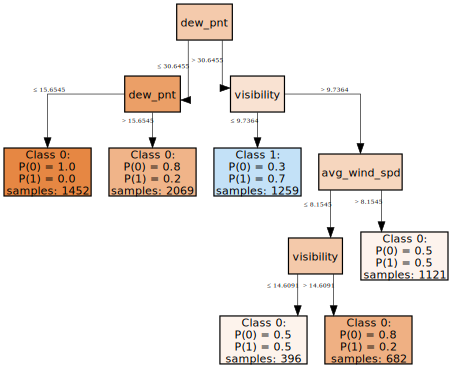

Accuracy: 74.38% - n_samples: 14000


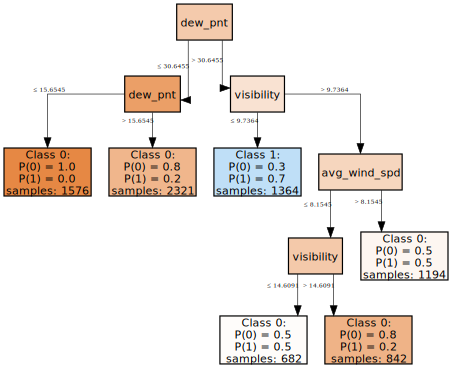

Accuracy: 74.57% - n_samples: 15000


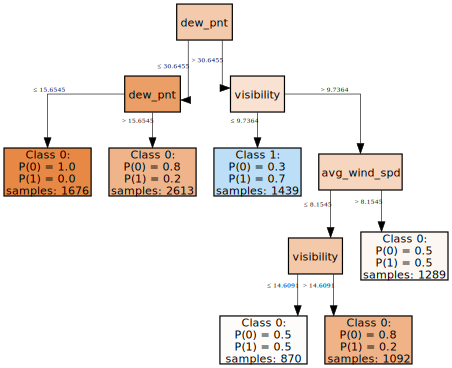

Accuracy: 74.57% - n_samples: 16000


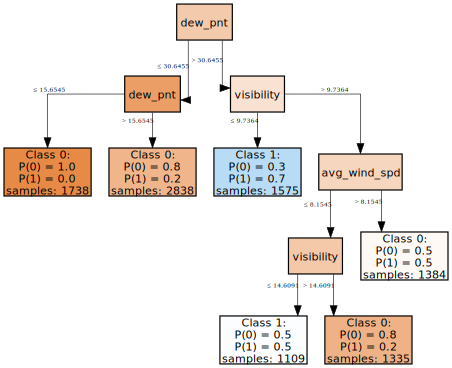

Accuracy: 74.45% - n_samples: 17000


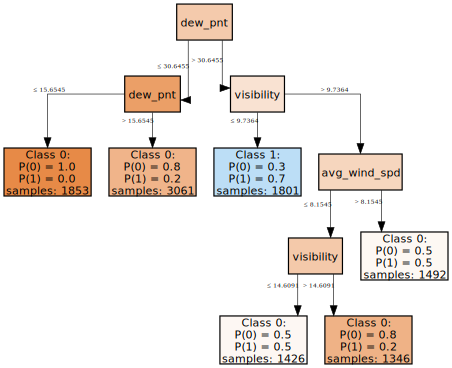

Accuracy: 74.16% - n_samples: 18000


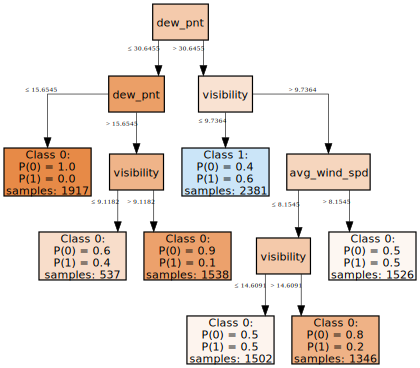

Accuracy: 74.15% - n_samples: 18159


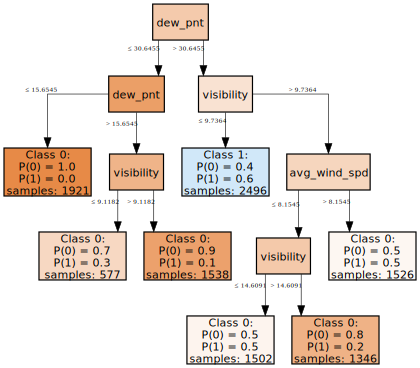

In [18]:
from IPython.display import display

for i in range(len(df) // 1000 + 1):
    chunk = itertools.islice(data, 1000)     # Get chunks of data from the stream
    for x, y in chunk:
        y_pred = model.predict_one(x)
        metric.update(y_true=y, y_pred=y_pred)
        model.learn_one(x, y)

    print(f'{metric} - n_samples: {metric.cm.n_samples}')
    display(model.draw())

## Pipelines
---

Pipelines are powerful tools that "chain" a sequence of operations. 

For example, the logistic regression model is sensitive to the scale of the features. Scaling the data so that each feature has mean $\mu=0$ and variance $\sigma^2=1$ is generally considered good practice. This is provided by the `StandardScaler` method within the `preprocessing` module of `River`.

We can apply the scaling and train the logistic regression sequentially in an elegant manner using a Pipeline.


In [19]:
from river import linear_model
from river import preprocessing
from river import compose

df = pd.read_csv("../datasets/NEweather.csv")
features = df.columns[:-2]
stream = stream.iter_pandas(X=df[features], y=df['rain'])

scaler = preprocessing.StandardScaler()
pipeline = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('log_reg', linear_model.LogisticRegression())
)

metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=stream,
                               model=pipeline,
                               metric=metric,
                               print_every=1000)

[1,000] Accuracy: 75.00%
[2,000] Accuracy: 76.35%
[3,000] Accuracy: 77.67%
[4,000] Accuracy: 76.83%
[5,000] Accuracy: 76.62%
[6,000] Accuracy: 76.52%
[7,000] Accuracy: 77.00%
[8,000] Accuracy: 76.42%
[9,000] Accuracy: 76.29%
[10,000] Accuracy: 76.30%
[11,000] Accuracy: 76.52%
[12,000] Accuracy: 76.75%
[13,000] Accuracy: 76.52%
[14,000] Accuracy: 76.35%
[15,000] Accuracy: 76.45%
[16,000] Accuracy: 76.50%
[17,000] Accuracy: 76.30%
[18,000] Accuracy: 76.21%
[18,159] Accuracy: 76.24%


Accuracy: 76.24%

We can visualize the pipeline by simply calling itself.

In [20]:
pipeline

Pipeline (
  StandardScaler (
    with_std=True
  ),
  LogisticRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Log (
      weight_pos=1.
      weight_neg=1.
    )
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

## Regression
---

### Bike Sharing data set

Contains the **hourly and daily count of rental bikes** between the years 2011 and 2012 in the Capital bike-share system with the corresponding weather and seasonal information. Attributes include weather, temperature, date, time, etc.

|      Attribute      | Description |
|:-------------------:|:-----------------------------------------------------------------|
| `instant`             | record index
| `dteday`              | date
| `season`              | (1:winter, 2:spring, 3:summer, 4:fall)
| `yr`                  | year (0: 2011, 1:2012)
| `mnth`                | month ( 1 to 12)
| `hr`                  | hour (0 to 23)
| `holiday`             | weather day is holiday or not
| `weekday`             | day of the week
| `workingday`          | if day is neither weekend nor holiday is 1, otherwise is 0.
| `weathersit`          | 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
| `temp`                | Normalized temperature in Celsius.
| `atemp`               | Normalized feeling temperature in Celsius.
| `hum`                 | Normalized humidity.
| `windspeed`           | Normalized wind speed.
| `casual`              | count of casual users
| `registered`          | count of registered users

**Target:** `cnt` | number of bikes rented including both casual and registered
 
**Number of samples:** 17,389

For this example we will use the k-nearest neighbor algorithm.

The implementation of KNN Regressor in `River` involves 3 parameters: 
- `n_neighbors`: Number of neighbors to search for.
- `engine`: Search engine used to store the instances and perform search queries. Based on the chosen engines, the search will be exact or approximate. The default engine used for the regressor would be SWINN (Sliding Window-based Nearest Neighbor search using Graphs).
- `aggregation_methos`: Method to aggregate the target value of neighbors. Including three methods: `mean`, `median`, and `weighted_mean`.

Basically, KNN regressor perform search queries in the data buffer using the defined engine, with predictions obtained by aggregating the values of the closest neighbors stored samples with respect to a query sample.

SWINN [(Saolo et al., 2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4292758) is a fairly new algorithm. It extends the NNDescend algorithm to handle vertex addition and removal in a FIFO data ingestion policy. The basic idea of SWINN (or NNDescend) is that "the neighbor of my neighbors might as well be my neighbors", and the algorithm can be described generally as follows:

- A random neighborhood graph is initiated.
- For each node in the search graph: refine the current neighborhood by checking if there are better neighborhood options among neighbors of the current neighbors.
- If the total number of neighborhood changes is smaller than a given stopping criterion, stop.

The algorithm is more effective when the maximum size of the data buffer is greater than $500$. For smaller data sizes, lazy search might be preferred.

In [21]:
from river import neighbors
from river.stream import iter_pandas

df = pd.read_csv("../datasets/bike.csv")
features = df.columns[:-2]

data = iter_pandas(X=df[features], y=df['cnt'])
model = neighbors.KNNRegressor(n_neighbors=3, aggregation_method="weighted_mean")
metric = metrics.R2()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               print_every=1000)

[1,000] R2: 0.825634
[2,000] R2: 0.8423
[3,000] R2: 0.843974
[4,000] R2: 0.883904
[5,000] R2: 0.893088
[6,000] R2: 0.886314
[7,000] R2: 0.883577
[8,000] R2: 0.879595
[9,000] R2: 0.864239
[10,000] R2: 0.86248
[11,000] R2: 0.867003
[12,000] R2: 0.875669
[13,000] R2: 0.8873
[14,000] R2: 0.891679
[15,000] R2: 0.897163
[16,000] R2: 0.898988
[17,000] R2: 0.895029
[17,379] R2: 0.894757


R2: 0.894757

The k-nearest neighbor algorithm assumes that all the features are numeric.

In the `bike` data, there are some categorical features. We can easily filter them in a pipeline:

In [22]:
data = iter_pandas(X=df[features], y=df['cnt'])
pipeline = (
    compose.Discard('season', 'mnth', 'weekday', 'weathersit') |
    neighbors.KNNRegressor(n_neighbors=3, aggregation_method="weighted_mean")
)
metric = metrics.R2()

evaluate.progressive_val_score(dataset=data,
                               model=pipeline,
                               metric=metric,
                               print_every=1000)

[1,000] R2: 0.848839
[2,000] R2: 0.682834
[3,000] R2: 0.727913
[4,000] R2: 0.716622
[5,000] R2: 0.707774
[6,000] R2: 0.659368
[7,000] R2: 0.632538
[8,000] R2: 0.600714
[9,000] R2: 0.592548
[10,000] R2: 0.620146
[11,000] R2: 0.627875
[12,000] R2: 0.626548
[13,000] R2: 0.642505
[14,000] R2: 0.640693
[15,000] R2: 0.644753
[16,000] R2: 0.637014
[17,000] R2: 0.623003
[17,379] R2: 0.616563


R2: 0.616563

In [23]:
pipeline

Pipeline (
  Discard (
    mnth
    season
    weathersit
    weekday
  ),
  KNNRegressor (
    n_neighbors=3
    engine=SWINN (
      graph_k=20
      dist_func=FunctionWrapper (
        distance_function=functools.partial(<function minkowski_distance at 0x127576280>, p=2)
      )
      maxlen=1000
      warm_up=500
      max_candidates=50
      delta=0.0001
      prune_prob=0.
      n_iters=10
      seed=None
    )
    aggregation_method="weighted_mean"
  )
)

## Concept Drift
---

Dynamic environments are challenging for machine learning methods because data changes over time.

For this example, we will generate a synthetic data stream by concatenating data from 3 different distributions:
- $dist_a$: $\mu=0.8$, $\sigma=0.05$
- $dist_b$: $\mu=0.4$, $\sigma=0.02$
- $dist_c$: $\mu=0.6$, $\sigma=0.1$.

In [25]:
import numpy as np
from utils import plot_data

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
data = np.concatenate((dist_a, dist_b, dist_c))


plot_data(dist_a, dist_b, dist_c)

Loading BokehJS ...

As observed above, the synthetic data stream has 3 **abrupt drifts**. An analogy could be trending topics on Twitter which can change quickly.

The goal is to detect that drift has occurred, after samples **1000** and **2000** in the synthetic data stream.

In this example, we will use the ADaptive WINdowing (`ADWIN`) drift detection method.



In [26]:
from river import drift

drift_detector = drift.ADWIN()
drifts = []

for i, val in enumerate(data):
    drift_detector.update(val)           # Data is processed one sample at a time
    if drift_detector.drift_detected:
        print(f'Change detected at index {i}')
        drifts.append(i)
        drift_detector._reset()           # As a best practice, we reset the detector

plot_data(dist_a, dist_b, dist_c, drifts)

Change detected at index 1055
Change detected at index 2079


### Impact on predictive performance

Concept drift can negatively impact learning methods if not properly handled. Multiple real-world applications suffer **model degradation** as the models can not adapt to changes in the data.

In this example, we will use two popular streaming models:

1. The `Hoeffding Tree`
2. The `Hoeffding Adaptive Tree`

The `Hoeffding Adaptive Tree` uses `ADWIN` to detect changes. If change is detected in a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

---
### `AGRAWAL` dataset

We will load the data from a csv file. The data was generated using the `AGRAWAL` data generator with 3 **gradual drifts** at the 5k, 10k, and 15k marks.

The `AGRAWAL` synthetic data generator produces 9 features, 6 numeric and 3 categorical.

There are 10 functions for generating binary class labels from the features. These functions determine whether a **loan** should be approved.

| Feature    | Description            | Values                                                                |
|------------|------------------------|-----------------------------------------------------------------------|
| `salary`     | salary                 | uniformly distributed from 20k to 150k                                |
| `commission` | commission             | if (salary <   75k) then 0 else uniformly distributed from 10k to 75k |
| `age`        | age                    | uniformly distributed from 20 to 80                                   |
| `elevel`     | education level        | uniformly chosen from 0 to 4                                          |
| `car`        | car maker              | uniformly chosen from 1 to 20                                         |
| `zipcode`    | zip code of the town   | uniformly chosen from 0 to 8                                          |
| `hvalue`     | value of the house     | uniformly distributed from 50k x zipcode to 100k x zipcode            |
| `hyears`     | years house owned      | uniformly distributed from 1 to 30                                    |
| `loan`       | total loan amount      | uniformly distributed from 0 to 500k                                  |

**Class:** `y` | 0: no loan, 1: loan
 
**Samples:** 20,000

`elevel`, `car`, and `zipcode` are categorical features.

In [27]:
df = pd.read_csv("../datasets/agr_a_20k.csv")
features = df.columns[:-2]

data = iter_pandas(X=df[features], y=df['class'])
model = tree.HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'])
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               show_memory=True,
                               print_every=1000)

[1,000] Accuracy: 82.08% – 6.5 KB
[2,000] Accuracy: 82.64% – 114.27 KB
[3,000] Accuracy: 83.79% – 114.27 KB
[4,000] Accuracy: 85.65% – 114.27 KB
[5,000] Accuracy: 86.50% – 85.02 KB
[6,000] Accuracy: 81.53% – 177.73 KB
[7,000] Accuracy: 79.15% – 181.31 KB
[8,000] Accuracy: 78.07% – 226.17 KB
[9,000] Accuracy: 78.45% – 309.89 KB
[10,000] Accuracy: 79.02% – 391.03 KB
[11,000] Accuracy: 77.44% – 465.57 KB
[12,000] Accuracy: 76.42% – 470.58 KB
[13,000] Accuracy: 75.88% – 472.39 KB
[14,000] Accuracy: 75.83% – 472.47 KB
[15,000] Accuracy: 75.93% – 489.17 KB
[16,000] Accuracy: 74.51% – 491.86 KB
[17,000] Accuracy: 73.56% – 491.86 KB
[18,000] Accuracy: 73.02% – 491.86 KB
[19,000] Accuracy: 72.65% – 491.86 KB
[20,000] Accuracy: 72.48% – 537.02 KB


Accuracy: 72.48%

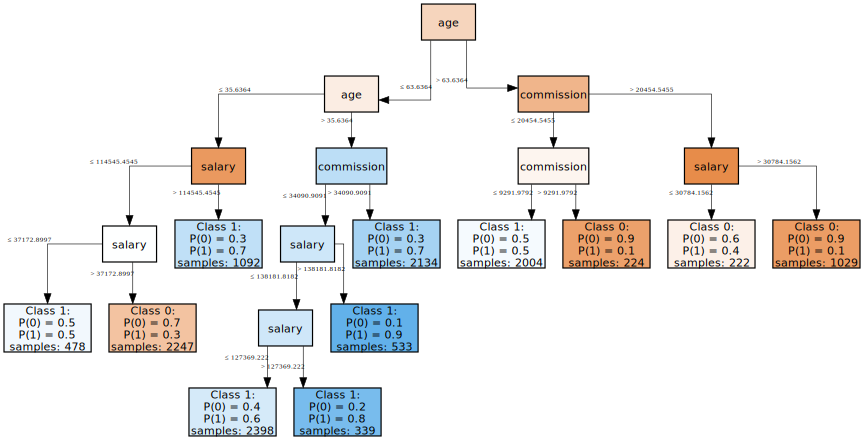

In [28]:
model.draw()

In [29]:
df = pd.read_csv("../datasets/agr_a_20k.csv")
features = df.columns[:-2]

data = iter_pandas(X=df[features], y=df['class'])
model = tree.HoeffdingAdaptiveTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'], seed=42)
metric = metrics.Accuracy()

evaluate.progressive_val_score(dataset=data,
                               model=model,
                               metric=metric,
                               show_memory=True,
                               print_every=1000)

[1,000] Accuracy: 83.28% – 123.6 KB
[2,000] Accuracy: 87.19% – 147.62 KB
[3,000] Accuracy: 88.60% – 147.87 KB
[4,000] Accuracy: 89.97% – 147.93 KB
[5,000] Accuracy: 90.44% – 165.49 KB
[6,000] Accuracy: 83.63% – 166.26 KB
[7,000] Accuracy: 79.07% – 262.69 KB
[8,000] Accuracy: 77.50% – 351.32 KB
[9,000] Accuracy: 76.94% – 420.88 KB
[10,000] Accuracy: 77.51% – 485.69 KB
[11,000] Accuracy: 77.33% – 212.54 KB
[12,000] Accuracy: 78.36% – 234.6 KB
[13,000] Accuracy: 79.36% – 234.79 KB
[14,000] Accuracy: 80.41% – 235.16 KB
[15,000] Accuracy: 81.19% – 316.38 KB
[16,000] Accuracy: 80.08% – 111.35 KB
[17,000] Accuracy: 80.05% – 163.57 KB
[18,000] Accuracy: 80.23% – 349.02 KB
[19,000] Accuracy: 80.26% – 555.3 KB
[20,000] Accuracy: 80.35% – 556.38 KB


Accuracy: 80.35%

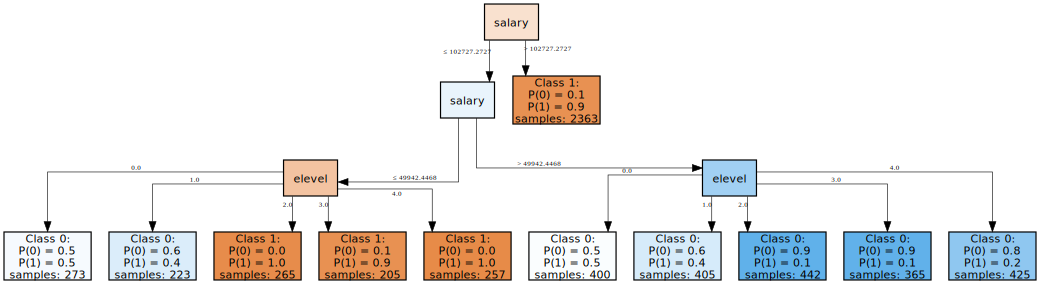

In [30]:
model.draw()

In [31]:
from river.tree import HoeffdingAdaptiveTreeClassifier
from river.stream import iter_pandas
from river.metrics import Accuracy

import pandas as pd

data = pd.read_csv("../datasets/agr_a_20k.csv")
features = data.columns[:-2]
stream = iter_pandas(X=data[features], y=data['class'])
model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'], 
                                        seed=42)
metric = Accuracy()

evaluate.progressive_val_score(dataset=stream, 
                               model=model, 
                               metric=metric, 
                               print_every=1000)

[1,000] Accuracy: 83.28%
[2,000] Accuracy: 87.19%
[3,000] Accuracy: 88.60%
[4,000] Accuracy: 89.97%
[5,000] Accuracy: 90.44%
[6,000] Accuracy: 83.63%
[7,000] Accuracy: 79.07%
[8,000] Accuracy: 77.50%
[9,000] Accuracy: 76.94%
[10,000] Accuracy: 77.51%
[11,000] Accuracy: 77.33%
[12,000] Accuracy: 78.36%
[13,000] Accuracy: 79.36%
[14,000] Accuracy: 80.41%
[15,000] Accuracy: 81.19%
[16,000] Accuracy: 80.08%
[17,000] Accuracy: 80.05%
[18,000] Accuracy: 80.23%
[19,000] Accuracy: 80.26%
[20,000] Accuracy: 80.35%


Accuracy: 80.35%

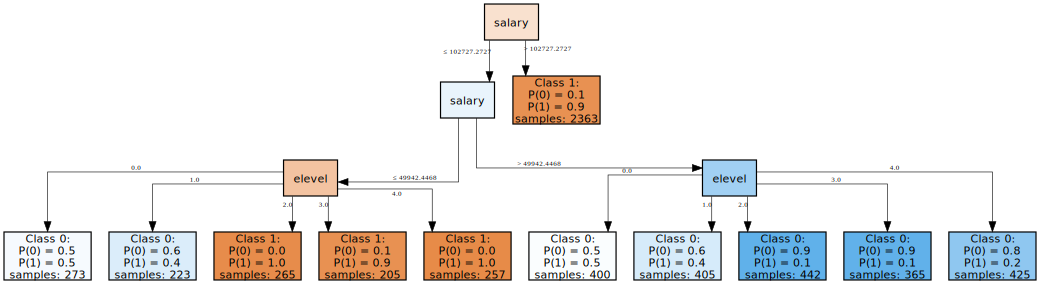

In [32]:
model.draw()

# Text clustering

The only text clustering algorithm implemented within `River` is `textClust`, a method proposed by Assembacher, D. and Trautmann, H. (2022).

`textClust` utilizes a widely popular two-phase clustering approach where the stream is first summarised in real-time, resulting in several micro-clusters that represent dense areas in the data space. The micro-clusters are presented as 3-tuples:

$$
mc = (TF, t, w)
$$
with 

- $mc.TF$ as a vector of token term frequencies as $n$-grams;
- $t$ as the last time the micro-cluster was updated; and
- $w$ as how often a new observation was merged into the cluster (indirectly depicting cluster importance).

To account for concept drift, the cluster weights are also exponentially faded each time a new observation appears in the data stream.

Later, when the algorithm is expected to output the final topics, these micro-clusters will be re-clustered into the final set of macro-clusters.

In [33]:
from river import compose
from river import feature_extraction
from river import metrics
from river import cluster

corpus = [
    {"text":'This is the first document.', "idd":1, "cluster":1},
    {"text":'This document is the improvement of the first document.', "idd":2, "cluster": 1},
    {"text":'And this is super unrelated.', "idd":3, "cluster": 2},
    {"text":'Is this the first document?',"idd":4, "cluster": 1},
    {"text":'This is super unrelated as well.',"idd":5, "cluster": 2},
    {"text":'This is a test sentence, unrelated to any other sentences.', "idd":6, "cluster": 3}
]

stopwords = ['stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I']

metric = metrics.AdjustedRand()

model = compose.Pipeline(
    feature_extraction.BagOfWords(lowercase=True, ngram_range=(1, 2), stop_words=stopwords),
    cluster.TextClust(real_time_fading=False, fading_factor=0.001, tgap=100, auto_r=True,
    radius=0.9)
)

y_preds = []

for x in corpus:
    y_pred = model.predict_one(x["text"])
    y_preds.append(y_pred)
    y = x["cluster"]
    metric = metric.update(y,y_pred)
    model = model.learn_one(x["text"])

print(metric)

AdjustedRand: -0.022727272727272728


In [34]:
model

Pipeline (
  BagOfWords (
    on=None
    strip_accents=True
    lowercase=True
    preprocessor=None
    stop_words=['I', 'a', 'and', 'in', 'is', 'it', 'stop', 'the', 'to']
    tokenizer_pattern="(?u)\b\w[\w\-]+\b"
    tokenizer=None
    ngram_range=(1, 2)
  ),
  TextClust (
    radius=0.9
    fading_factor=0.001
    tgap=100
    term_fading=True
    real_time_fading=False
    micro_distance=distances (
      type="tfidf_cosine_distance"
    )
    macro_distance=distances (
      type="tfidf_cosine_distance"
    )
    num_macro=3
    min_weight=0
    auto_r=True
    auto_merge=True
    sigma=1
  )
)

In [35]:
print(y_preds)

[None, 0, 0, 0, 2, 2]


# Anomaly detection
---

In this section, we will introduce one of the newly implemented anomaly detection in `River`, the incremental Local Outlier Factor (LOF). ILOF is an incremental version of the Local Outlier Factor (LOF), used to identify outliers based on density of local neighbors.

The algorithm takes into account the following elements:

- `NewPoint`: new point to be learned/predicted;
- `kNN(p)`: the neighbors of the point `p` (k closest points of `p`);
- `RkNN(p)`: the reverse neighboors of `p` (points that have `p` as one of their neighboors);
- Set of points that needs the local reachability distance updated;
- Set of points that needs the local outlier factor updated.

Moreover, the incremental LOF algorithm is designed to satisfy the need of insertion and deletion of a record to and from a data stream, without the need of re-running the algorithm from the beginning.

The implemented algorithm, based on the original version described in the paper of Pokrajak et al. (2007), conducts the following steps:

1. Insert a new point and calculate its distance to observed points;

2. Update the neighbors and reverse neighbors of all points;

3. Define the set of affected points that require updates;

4. Calculate the reachability distance from the new point to its neighbors (`NewPoint -> kNN(NewPoint)`) and from the reverse neighbor of the new point `p` to itself (`RkNN(NewPoint) -> NewPoint`);

$$
reach\_dist_k(q,p) = max(d(q,p), k\_distance(p))
$$

5. Update the reachability distance of affected points (i.e reachability distance from the reverse neighbors of reverse neighbors of the point `p` to the reverse neighbors of that specific point) (`RkNN(RkNN(NewPoints)) -> RkNN(NewPoints)`);

6. Update the local reachability distance of affected points;
$$
lrd(q) = \frac{1}{\sum_{p \in kNN(q)} reach\_dist_k (q,p) / k}
$$

7. Compute the local outlier factor of the set of affected points;

$$
LOF(q) = \frac{\frac{1}{k} \sum_{p \in kNN (q)} lrd(p)}{lrd(q)}
$$

[Pokrajak et al. (2007)] David Pokrajak, Aleksandar Lazarevic and Longin Jan Latecki (2007). Incremental Local Outlier Detection for Data Streams. In *Proceedings of the 2007 IEEE Symposium on Computational Intelligence and Data Mining* (CIDM 2007), p. 504-515. 10.1109/CIDM.2007.368917. 

## Synthetic data generation

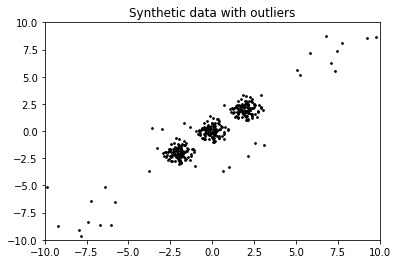

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import neighbors

from river import anomaly, datasets
from river.utils import dict2numpy

np.random.seed(42)

# generation of training dataset
norm_dist = 0.5 * np.random.randn(100, 2)
x_inliers = np.concatenate((norm_dist - 2, norm_dist, norm_dist + 2), axis=0)
x_outliers = np.concatenate(
    (
        np.random.uniform(low=-4, high=4, size=(20, 2)),
        np.random.uniform(low=-10, high=-5, size=(10, 2)),
        np.random.uniform(low=5, high=10, size=(10, 2)),
    ),
        axis=0,
)
x_train = np.concatenate((x_inliers, x_outliers), axis=0)
x_train_dict = [{f"feature_{i + 1}": elem[i] for i in range(2)} for elem in x_train]
ground_truth = np.ones(len(x_train), dtype=int)
ground_truth[-len(x_outliers) :] = -1
df_train = pd.DataFrame({"observations": x_train_dict, "ground_truth": ground_truth})

# data visualization
plt.title("Synthetic data with outliers")
plt.scatter(x_train[:, 0], x_train[:, 1], color="k", s=3.0)
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()

In [37]:
# initiation of the model
incremental_lof = anomaly.LocalOutlierFactor(n_neighbors=20)

for x in df_train["observations"]:
    incremental_lof.learn_one(x)
    
ilof_scores_train = np.array([ilof_score for ilof_score in incremental_lof.lof.values()])

# generation of tested dataset
x_pred = np.random.uniform(low=-5, high=5, size=(30, 2))
x_pred_dict = [{f"feature_{i + 1}": elem[i] for i in range(2)} for elem in x_pred]

From the current state of the model, we will evaluate the LOF scores of all data points in the test dataset without actually learning the model anymore. By this way, the model will return LOF scores but itself will not be updated throughout the process. By this, we can compare the outputs generated by the model implemented by `River` with the outputs generated by the batch version of LOF implemented in `scikit-learn`.

In [38]:
ilof_scores_pred = []
for x in x_pred_dict:
    ilof_scores_pred.append(incremental_lof.score_one(x))
    
# Traditional batch LOF with scikit-learn
lof_sklearn = neighbors.LocalOutlierFactor(n_neighbors=20)
lof_sklearn.fit_predict(x_train)
lof_sklearn_scores_train = -lof_sklearn.negative_outlier_factor_


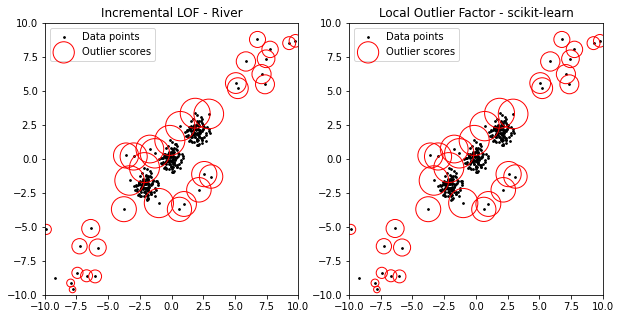

In [39]:
fig, axis = plt.subplots(ncols=2, figsize=(10, 5))

# First plot
radius1 = (ilof_scores_train.max() - ilof_scores_train) / (ilof_scores_train.max() - ilof_scores_train.min()) * (ilof_scores_train > 1.5)
axis[0].set_title("Incremental LOF - River")
axis[0].scatter(x_train[:, 0], x_train[:, 1], color="k", s=3.0, label="Data points")
axis[0].axis("tight")
axis[0].set_xlim((-10, 10))
axis[0].set_ylim((-10, 10))
axis[0].scatter(x_train[:, 0], x_train[:, 1], s=1000 * radius1, edgecolors="r", facecolors="none", label="Outlier scores")
axis[0].legend(loc="upper left")

# Second plot
radius2 = (max(lof_sklearn_scores_train) - lof_sklearn_scores_train) / (max(lof_sklearn_scores_train) - min(lof_sklearn_scores_train)) * (lof_sklearn_scores_train > 1.5)
axis[1].set_title("Local Outlier Factor - scikit-learn")
axis[1].scatter(x_train[:, 0], x_train[:, 1], color="k", s=3.0, label="Data points")
axis[1].axis("tight")
axis[1].set_xlim((-10, 10))
axis[1].set_ylim((-10, 10))
axis[1].scatter(x_train[:, 0], x_train[:, 1], s=1000 * radius2, edgecolors="r", facecolors="none", label="Outlier scores")
axis[1].legend(loc="upper left")

plt.show()

With the radius from the above figure calculated as

$$
r(p) = 1_{LOF > 1.5} \times \frac{\max(LOF) - LOF}{\max(LOF) - \min(LOF)}
$$

We will show that the difference in the results of these two algorithms is at machine-error level.

In [40]:
assert np.allclose(ilof_scores_train, lof_sklearn_scores_train, rtol=1e-08, atol=1e-08)

## Time comparison

In [41]:
import time 
cc_df = pd.DataFrame(datasets.CreditCard())
cc_df_np = [dict2numpy(i) for i in cc_df[0].to_dict().values()]

Regarding time comparison, we will use the command `learn_many` provided with the algorithm within `River` instead of using the `for` loop for `learn_one` since this will make the updating process of affected points conducted multiple times instead of one for each batch. This command allows us to learn multiple observations at the same time, which would provide a fairer comparison towards the batch learning habit of `scikit-learn`.

Moreover, `scikit-learn` has applies methods like tree search that optimize the search for neighboors so its execution time remains more of less constant

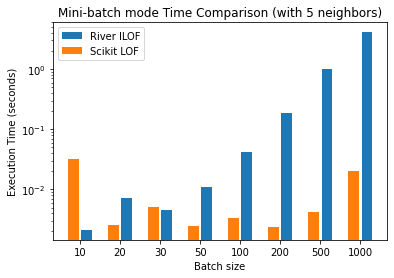

In [42]:
batch_sizes = [10, 20, 30, 50, 100, 200, 500, 1000]

execution_time_river = []
execution_time_sklearn = []

for batch_size in batch_sizes:
    # River
    start_time_river = time.time()
    ilof_river_batch = anomaly.LocalOutlierFactor(n_neighbors=5)
    ilof_river_batch.learn_many(cc_df[0:batch_size])
    end_time_river = time.time()
    execution_time_river.append(end_time_river - start_time_river)
    ilof_scores_river_batch = np.array([v for v in ilof_river_batch.lof.values()])
    
    #scikit-learn
    start_time_sklearn = time.time()
    lof_sklearn_batch = neighbors.LocalOutlierFactor(n_neighbors=5)
    lof_sklearn_batch.fit_predict(cc_df_np[0:batch_size])
    end_time_sklearn = time.time()
    execution_time_sklearn.append(end_time_sklearn - start_time_sklearn)
    lof_scores_sklearn_batch = -lof_sklearn_batch.negative_outlier_factor_
    
plt.bar(np.array(range(len(execution_time_river)))*1.5+0.25, execution_time_river, width=0.4, label='River ILOF')
plt.bar(np.array(range(len(execution_time_sklearn)))*1.5-0.25, execution_time_sklearn, width=0.4, label='Scikit LOF')
plt.xticks(np.array(range(len(execution_time_river)))*1.5, batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Execution Time (seconds)')
plt.title('Mini-batch mode Time Comparison (with 5 neighbors)')
plt.yscale('log')
plt.legend()
plt.show()


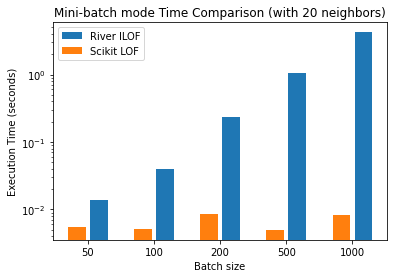

In [43]:
batch_sizes = [50, 100, 200, 500, 1000]

execution_time_river = []
execution_time_sklearn = []

for batch_size in batch_sizes:
    # River
    start_time_river = time.time()
    ilof_river_batch = anomaly.LocalOutlierFactor(n_neighbors=20)
    ilof_river_batch.learn_many(cc_df[0:batch_size])
    end_time_river = time.time()
    execution_time_river.append(end_time_river - start_time_river)
    ilof_scores_river_batch = np.array([v for v in ilof_river_batch.lof.values()])
    
    #scikit-learn
    start_time_sklearn = time.time()
    lof_sklearn_batch = neighbors.LocalOutlierFactor(n_neighbors=20)
    lof_sklearn_batch.fit_predict(cc_df_np[0:batch_size])
    end_time_sklearn = time.time()
    execution_time_sklearn.append(end_time_sklearn - start_time_sklearn)
    lof_scores_sklearn_batch = -lof_sklearn_batch.negative_outlier_factor_
    
plt.bar(np.array(range(len(execution_time_river)))*1.5+0.25, execution_time_river, width=0.4, label='River ILOF')
plt.bar(np.array(range(len(execution_time_sklearn)))*1.5-0.25, execution_time_sklearn, width=0.4, label='Scikit LOF')
plt.xticks(np.array(range(len(execution_time_river)))*1.5, batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Execution Time (seconds)')
plt.title('Mini-batch mode Time Comparison (with 20 neighbors)')
plt.yscale('log')
plt.legend()
plt.show()


The more observations in the batch, the more time `River` will take compared with the batch version of `sklearn` to learn. This can be explained by the fact that incremental LOF calculates the distance of the new points to all other points at each iteration.